Dense Layer를 활용하여 주식 예측해보기 <br>
데이터셋 조건 : 1조, 거래일 10일, next_change : 0.02 <br>
Final earning rate : -22.86 %<br>
모델 선택 시 Dense Layer 고려 



In [2]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
  
    
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


# 데이터셋 불러오기

In [4]:
def load_file(TYPE,trading, days,target):
    with open('../data/{}_{}_{}_{}.pickle'.format(TYPE,trading, days,target), 'rb') as f:
        data = pickle.load(f)
    return data

In [5]:
def load_model(model,trading, days,target):
    with open('../model/{}_{}_{}_{}.pickle'.format(model,trading, days,target), 'rb') as f:
        model = pickle.load(f)
    return model

In [6]:
train = load_file('train',10000,10,0.02)
val = load_file('val',10000,10,0.02)
test = load_file('test', 10000,10,0.02)

In [8]:
lst_code2date_train = []
trainX = []
trainY = []

for line in train:
    code, date, x, y = line
    lst_code2date_train.append([code,date])
    trainX.append(list(map(int, x.split(','))))
    trainY.append(int(y))
trainX=np.array(trainX)
trainY=np.array(trainY)

In [13]:
lst_code2date_val = []
valX=[]
valY=[]

for line in val:
    code, date, x, y = line
    lst_code2date_val.append([code,date])
    valX.append(list(map(int, x.split(','))))
    valY.append(int(y))
valX=np.array(valX)
valY=np.array(valY)

In [11]:
lst_code2date_test = []
testX=[]
testY=[]

for line in test:
    code, date, x, y = line
    lst_code2date_test.append([code,date])
    testX.append(list(map(int, x.split(','))))
    testY.append(int(y))
testX=np.array(testX)
testY=np.array(testY)

# Modeling

In [14]:
from tqdm.notebook import tqdm
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(trainX.shape[1])))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='hard_sigmoid'))
model.add(keras.layers.Dense(128, activation='hard_sigmoid'))
model.add(keras.layers.Dense(64, activation='hard_sigmoid'))
model.add(keras.layers.Dense(32, activation='hard_sigmoid'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
    
model.compile(optimizer=keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.ExponentialDecay(0.01,decay_steps=100000,decay_rate=0.96)), 
    loss="binary_crossentropy",
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               13056     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 56,321
Trainable params: 56,321
Non-trainable params: 0
____________________________________________________

In [15]:
es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, verbose=1, mode="auto", restore_best_weights=True)
lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
sv = keras.callbacks.ModelCheckpoint(
    "./model_keras_mlp.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
    )

history = model.fit(trainX, trainY, validation_split=0.20, batch_size=128, epochs=50, callbacks=[es, sv], shuffle=True)            

Epoch 1/50
3/3 [==============================] - 2s 235ms/step - loss: 0.7188 - accuracy: 0.4949 - val_loss: 0.6023 - val_accuracy: 0.7143

Epoch 00001: val_accuracy improved from -inf to 0.71429, saving model to .\model_keras_mlp.h5
Epoch 2/50
3/3 [==============================] - 0s 35ms/step - loss: 0.6866 - accuracy: 0.4995 - val_loss: 0.5907 - val_accuracy: 0.7571

Epoch 00002: val_accuracy improved from 0.71429 to 0.75714, saving model to .\model_keras_mlp.h5
Epoch 3/50
3/3 [==============================] - 0s 29ms/step - loss: 0.6215 - accuracy: 0.7129 - val_loss: 0.5908 - val_accuracy: 0.8000

Epoch 00003: val_accuracy improved from 0.75714 to 0.80000, saving model to .\model_keras_mlp.h5
Epoch 4/50
3/3 [==============================] - 0s 30ms/step - loss: 0.5902 - accuracy: 0.7456 - val_loss: 0.5223 - val_accuracy: 0.7714

Epoch 00004: val_accuracy did not improve from 0.80000
Epoch 5/50
3/3 [==============================] - 0s 32ms/step - loss: 0.5533 - accuracy: 0.7415

In [18]:
# load a saved model
from tensorflow.keras.models import load_model
saved_model = load_model('./model_keras_mlp.h5')
predY = model.predict(valX)
predY[:5]

array([[0.658133  ],
       [0.65446424],
       [0.72243625],
       [0.70702267],
       [0.7305692 ]], dtype=float32)

## 손실 그래프 그리기

In [19]:
import matplotlib.pyplot as plt

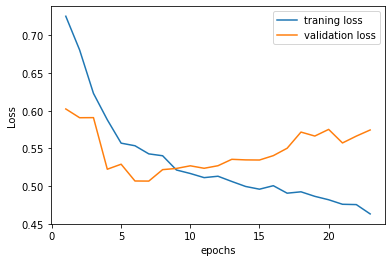

In [20]:
epochs = np.arange(1,len(history.history['loss'])+1)
plt.plot(epochs,history.history['loss'], label = 'traning loss')
plt.plot(epochs, history.history['val_loss'], label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
lst_output = []

for (code,date),y in zip(lst_code2date_test, predY):
    if y >= 0.9:
        lst_output.append([code, date, 'buy','r80'])
        lst_output.append([code, date+"n", 'sell', 'all'])
    elif y >= 0.7:
        lst_output.append([code, date, 'buy','r50'])
        lst_output.append([code, date+"n", 'sell', 'all'])
    elif y >= 0.5:
        lst_output.append([code, date, 'buy', 'r30'])
        lst_output.append([code, date+"n", 'sell', 'all'])
    elif y >= 0.3:
        lst_output.append([code, date, 'buy', 'r10'])
        lst_output.append([code, date+"n", 'sell', 'all'])

In [24]:
lst_output[:50]

[['222080', '20210930', 'buy', 'r30'],
 ['222080', '20210930n', 'sell', 'all'],
 ['035080', '20210714', 'buy', 'r30'],
 ['035080', '20210714n', 'sell', 'all'],
 ['028300', '20210830', 'buy', 'r50'],
 ['028300', '20210830n', 'sell', 'all'],
 ['064260', '20211118', 'buy', 'r50'],
 ['064260', '20211118n', 'sell', 'all'],
 ['064260', '20211119', 'buy', 'r50'],
 ['064260', '20211119n', 'sell', 'all'],
 ['038070', '20210820', 'buy', 'r30'],
 ['038070', '20210820n', 'sell', 'all'],
 ['019170', '20210812', 'buy', 'r30'],
 ['019170', '20210812n', 'sell', 'all'],
 ['036570', '20211111', 'buy', 'r10'],
 ['036570', '20211111n', 'sell', 'all'],
 ['036570', '20211112', 'buy', 'r10'],
 ['036570', '20211112n', 'sell', 'all'],
 ['035420', '20210908', 'buy', 'r10'],
 ['035420', '20210908n', 'sell', 'all'],
 ['000660', '20210811', 'buy', 'r30'],
 ['000660', '20210811n', 'sell', 'all'],
 ['000660', '20210812', 'buy', 'r50'],
 ['000660', '20210812n', 'sell', 'all'],
 ['000660', '20210813', 'buy', 'r50'],
 

In [16]:
lst_output.sort(key = lambda x: x[1]) # date 기준으로 주문 요청 결과 정렬

OF = open('../data/order_request_dense.txt','w')
for row in lst_output:
    OF.write('\t'.join(map(str, row)) + '\n')
OF.close()

# 수익률 계산

In [40]:
import pymysql
import warnings
warnings.filterwarnings(action ='ignore')
# database
# con = pymysql.connect()

cursor = con.cursor()

In [22]:
start_money = 10000000 # 초기 현금 1천만원
money = start_money
dic_code2num ={}  # 보유 종목


IF = open('../data/order_request_dense.txt','r')
for i, line in tqdm(enumerate(IF)): #주문 일지를 한 줄 읽어 옴
    code, date, request, amount = line.strip().split("\t")
    
    ##############################################################################################
    sql_query = '''
                SELECT *
                FROM stock_{}
                WHERE Date
                BETWEEN '2021-01-01' AND '2021-07-01'
                '''.format(code)
    stock = pd.read_sql(sql = sql_query, con = con)
    lst_stock = stock.values.tolist()
    
    for idx, row in enumerate(lst_stock):
        Date = row[0].strftime('%Y%m%d')        
        if date.endswith('n'):
            if date.rstrip('n') == Date:
                sell_close = lst_stock[idx+1][4]
        elif date == Date:
            buy_close = lst_stock[idx][4]

    ##############################################################################################
    
    if request == 'buy': # buy인 경우
        if amount.startswith('r'):
            request_money = money * float(amount.lstrip("r")) / 100
        elif amount == 'all':
            request_money = money
        elif amount.isdigit():
            request_money = int(amount)
        # elif amount == ~~~~~    ##### 기타 필요한 매수 요청 옵션이 있을 시 작성
        else:
            raise Exception('Not permitted option')
        request_money = min(request_money, money)
        buy_num = int(request_money / buy_close)
        money -= buy_num * buy_close  # 현재 금액(money)을 실제 매수액을 뺀 만큼 업데이트
        if code not in dic_code2num:
            dic_code2num[code] = 0
        dic_code2num[code] += buy_num # 보유 종목 데이터에 구매 종목(code)를 매수 개수 만큼 증가
    if request == 'sell': # sell인 경우
        if amount == 'all':
            sell_num = dic_code2num[code]
        # elif amount == ~~~~~    ##### 기타 필요한 매도 요청 옵션이 있을 시 작성
        else:
            raise Exception('Not permitted option')            
        money += sell_num * sell_close
        dic_code2num[code] -= sell_num
        if dic_code2num[code] == 0:
            del dic_code2num[code]
IF.close()            
            
if dic_code2num != {}: # 매매가 종료되었는데 보유 종목이 있으면
    raise Exception('Not empty stock') 

print("Final earning rate : {} %".format(str((money-start_money) / start_money * 100)))

0it [00:00, ?it/s]

Final earning rate : -22.86496 %
